## Kernel Density Funcs

In [27]:
######################################################
##
## Probability Density Function (PDF) Estimation
##
######################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap
from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 50000
batch_size = 10
learning_rate =  0.001    ## 0.01   ## 1e-5 

## probably need adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

## Assume 400 predicted errors with Unknown distribution

400


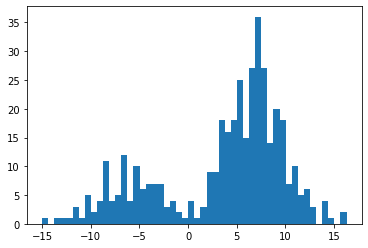

In [2]:


error1 = normal(loc=7, scale=3, size=300)
error2 = normal(loc=-7, scale=3, size=100)


errors = hstack((error1, error2))

print(len(errors))

plt.hist(errors, bins=50)
plt.show()


In [3]:
print(errors[:].shape)
errors[:]

(400,)


array([  9.93483921,   4.56793863,   7.34833784,   5.04688106,
         8.35059195,   9.29002843,  13.82188623,   8.13791595,
        10.20967991,   7.41908479,   1.8158371 ,   7.30884495,
        11.11783273,   4.89506178,   3.10316048,  11.34848019,
         6.94587513,   5.08933338,  -1.75706249,   8.40185134,
         9.15964251,   1.76788749,   6.81939648,   9.69039739,
        10.48550481,   8.57163185,  12.19267825,   5.58274491,
         9.03840788,   7.40520903,   6.70748633,   3.7200864 ,
         7.91778898,   2.08832629,   6.4683635 ,   4.96110525,
         7.6926167 ,   8.24122587,   9.57420015,  10.04716116,
        10.01931977,   6.22790991,   6.01479022,  12.17447279,
         6.80079734,   4.71350678,   2.79555199,   7.03132063,
         2.68986895,   9.3294243 ,   5.49004928,   4.84669953,
         6.49415374,  14.04158122,   5.60510482,   7.07727115,
         6.32751835,   9.8855198 ,  12.26683295,   9.12304158,
         7.8453933 ,   4.3556602 ,   3.43528167,   2.23

## Learn the function that predicts the unknown error distribution

* sum of basis funcs (e.g. sum of gaussians)

In [4]:

## Bandwidth (smoothing parameter) is a window size required by the algorithm that controls 
## the number of observations (samples) to look at per new point to estimate. 
## The kernel is the basis function. 



def sum_of_basis_func(errors, bandwidth):
    
    model = KernelDensity(bandwidth=bandwidth, kernel='gaussian')

    errors = errors.reshape(  (len(errors), 1)   )              ## 1000x1

    model.fit(errors)
    
    return model


In [5]:

bandwidth = 2

basis_func_trained = sum_of_basis_func(errors,  bandwidth)


## This is the scale in which to compare impulse to unknown error distribution 

* [-20, 20] with step 0.1 which will give a vector of 4000

In [6]:

N_error_range = 20

x = torch.arange(-N_error_range, N_error_range, 0.01)                   ## the error is in this range 

In [7]:
x

tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])

## Given x range [-20,20] predict using learned error PDF func

In [12]:

x = x.reshape(   (len(x), 1)    )

print(x.shape)

probabilities = basis_func_trained.score_samples(x) 
print(probabilities)
print(probabilities.shape)



torch.Size([4000, 1])
[-10.57284086 -10.55962246 -10.54642586 ...  -8.54361103  -8.55447707
  -8.5653629 ]
(4000,)


## Now invert from log space to exponent space 

In [13]:

probabilities_exp = exp(probabilities)
print(probabilities_exp)
print(probabilities_exp.shape)



[0.0000256  0.00002594 0.00002629 ... 0.00019479 0.00019268 0.00019059]
(4000,)


## The yellow line is the preds using the learned unknown func 

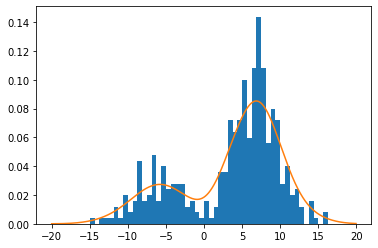

In [14]:
plt.hist(errors, bins=50, density=True)     ## see probs instead of counts with density=True
plt.plot(x[:], probabilities_exp)          ## reshaped to 2D
plt.show()

## This is the vector that will be compared to the impulse func

* size 4000

In [15]:

print(probabilities_exp)
print(probabilities_exp.shape)


[0.0000256  0.00002594 0.00002629 ... 0.00019479 0.00019268 0.00019059]
(4000,)


In [16]:
probabilities_exp[1000:2000]

array([0.01524646, 0.01528832, 0.0153302 , 0.01537211, 0.01541404,
       0.01545599, 0.01549796, 0.01553995, 0.01558197, 0.01562401,
       0.01566606, 0.01570814, 0.01575023, 0.01579234, 0.01583447,
       0.01587661, 0.01591878, 0.01596096, 0.01600315, 0.01604536,
       0.01608758, 0.01612981, 0.01617206, 0.01621432, 0.01625659,
       0.01629888, 0.01634117, 0.01638347, 0.01642579, 0.01646811,
       0.01651044, 0.01655278, 0.01659512, 0.01663748, 0.01667983,
       0.01672219, 0.01676456, 0.01680693, 0.01684931, 0.01689168,
       0.01693406, 0.01697644, 0.01701882, 0.0170612 , 0.01710358,
       0.01714596, 0.01718834, 0.01723071, 0.01727309, 0.01731546,
       0.01735782, 0.01740018, 0.01744253, 0.01748488, 0.01752723,
       0.01756956, 0.01761189, 0.01765421, 0.01769652, 0.01773881,
       0.0177811 , 0.01782338, 0.01786564, 0.01790789, 0.01795013,
       0.01799236, 0.01803457, 0.01807676, 0.01811894, 0.01816111,
       0.01820325, 0.01824538, 0.01828749, 0.01832958, 0.01837

In [17]:
probabilities_exp[2000:3000]

array([0.01845903, 0.01849452, 0.01853045, 0.01856683, 0.01860365,
       0.01864092, 0.01867863, 0.01871678, 0.01875539, 0.01879444,
       0.01883394, 0.01887388, 0.01891428, 0.01895513, 0.01899643,
       0.01903817, 0.01908037, 0.01912303, 0.01916613, 0.01920969,
       0.0192537 , 0.01929816, 0.01934308, 0.01938846, 0.01943429,
       0.01948058, 0.01952732, 0.01957452, 0.01962218, 0.01967029,
       0.01971886, 0.01976789, 0.01981738, 0.01986733, 0.01991773,
       0.0199686 , 0.02001993, 0.02007171, 0.02012396, 0.02017666,
       0.02022983, 0.02028346, 0.02033754, 0.02039209, 0.0204471 ,
       0.02050257, 0.02055851, 0.0206149 , 0.02067176, 0.02072908,
       0.02078685, 0.0208451 , 0.0209038 , 0.02096296, 0.02102259,
       0.02108268, 0.02114323, 0.02120424, 0.02126571, 0.02132765,
       0.02139004, 0.0214529 , 0.02151622, 0.02158   , 0.02164424,
       0.02170894, 0.0217741 , 0.02183972, 0.0219058 , 0.02197235,
       0.02203935, 0.02210681, 0.02217472, 0.0222431 , 0.02231

## Probabilities_exp adds up to 1.0  (Unknown error PDF)

* (unknown error vector size 4000)
* this vector is what compared to impulse vector of size 4000

In [46]:
sum(probabilities_exp)

99.9830079457722

## Impulse function 

* the produced vector of size 4000 is basically a constant of vector size 4000

In [47]:

def ImpulseGaussian(x, mu, sigma): 
   
    left  = 1 / (    torch.sqrt(   2 * torch.tensor(math.pi)   ) * torch.sqrt(torch.tensor(sigma) )    )
    
    right = torch.exp(   -(x - mu)**2 / (2 * sigma)    )
    
    vector_vals = left * right
    
    return vector_vals         ## .unsqueeze(0)


In [48]:

mean_impulse    = 0.0
std_impulse     = 0.01


In [49]:

impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)  


In [50]:
impulseFunc.shape

torch.Size([4000, 1])

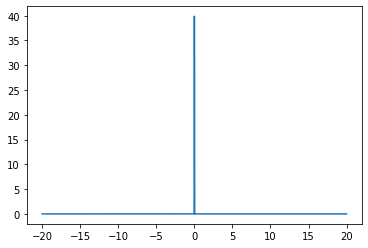

In [51]:

plt.plot(x, impulseFunc)
plt.show()


## Impulse function vector of size 4000 adds up to 1.0 

In [52]:
impulseFunc = impulseFunc/100.0

In [53]:
sum(impulseFunc)

tensor([1.])

In [54]:
impulseFunc

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [55]:
impulseFunc[1970:2030]

tensor([[    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0001],
        [    0.0044],
        [    0.0540],
        [    0.2420],
        [    0.3989],
        [    0.2420],
        [    0.0540],
        [    0.0044],
        [    0.0001],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [ 